### 1. <a id='importation'>Détail des données fournies</a>

In [14]:
import time
import warnings

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeClassifier

# Ignorer les avertissements
warnings.filterwarnings('ignore')
path = "../data/"

DELIMITER = "--------------------------------"

---

### 2. <a id='chargement'>Chargement et initialisation des données</a>

In [15]:
#On vient charger les différents dataset
employee_df = pd.read_csv(path + "employee_survey_data.csv")
general_df = pd.read_csv(path + "general_data.csv")
manager_df = pd.read_csv(path + "manager_survey_data.csv")
in_time_df = pd.read_csv(path + "in_time.csv")
out_time_df = pd.read_csv(path + "out_time.csv")

dataframes = [
    ("employee_df", employee_df),
    ("general_df", general_df),
    ("manager_df", manager_df),
    ("in_time_df", in_time_df),
    ("out_time_df", out_time_df)
]

for name, df in dataframes:
    print(DELIMITER)
    print(f"Nom du DataFrame : {name}")
    print(f"Description : {df.describe()}")
    print(f"Valeurs nulles : ")
    print(f"{df.isnull().sum()}")


--------------------------------
Nom du DataFrame : employee_df
Description :         EmployeeID  EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance
count  4410.000000              4385.000000      4390.000000      4372.000000
mean   2205.500000                 2.723603         2.728246         2.761436
std    1273.201673                 1.092756         1.101253         0.706245
min       1.000000                 1.000000         1.000000         1.000000
25%    1103.250000                 2.000000         2.000000         2.000000
50%    2205.500000                 3.000000         3.000000         3.000000
75%    3307.750000                 4.000000         4.000000         3.000000
max    4410.000000                 4.000000         4.000000         4.000000
Valeurs nulles : 
EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64
--------------------------------
Nom du DataFrame : general_df
Descri

---

Résumé des différentes données présentes dans les dataset:

**Dataset employee_survey_data**
| #  | Colonne                   | Type      | Description                                    | Valeurs manquantes | Moyenne | Médiane | Min | Max |
|----|---------------------------|-----------|-----------------------------------------------|--------------------|---------|---------|-----|-----|
| 1  | EmployeeID                | int64     | Identifiant unique pour chaque employé       | 0                  | -       | -       | -   | -   |
| 2  | EnvironmentSatisfaction   | float64   | Satisfaction par rapport à l’environnement   | 25                 | 2.72    | 3       | 1   | 4   |
| 3  | JobSatisfaction           | float64   | Satisfaction au travail                      | 20                 | 2.73    | 3       | 1   | 4   |
| 4  | WorkLifeBalance           | float64   | Équilibre vie pro/perso                      | 38                 | 2.76    | 3       | 1   | 4   |

**Dataset general_data**
| #  | Colonne                     | Type      | Description                                    | Valeurs manquantes | Moyenne   | Médiane | Min | Max      |
|----|-----------------------------|-----------|-----------------------------------------------|--------------------|-----------|---------|-----|----------|
| 1  | Age                         | int64     | Âge des employés                              | 0                  | 36.92     | 36      | 18  | 60       |
| 2  | Attrition                   | object    | Indique si l'employé a quitté l'entreprise    | 0                  | -         | -       | -   | -        |
| 3  | BusinessTravel              | object    | Fréquence des déplacements professionnels     | 0                  | -         | -       | -   | -        |
| 4  | Department                  | object    | Département auquel l'employé appartient       | 0                  | -         | -       | -   | -        |
| 5  | DistanceFromHome            | int64     | Distance entre domicile et lieu de travail    | 0                  | 9.19      | 7       | 1   | 29       |
| 6  | Education                   | int64     | Niveau d'éducation (1 à 5)                    | 0                  | 2.91      | 3       | 1   | 5        |
| 7  | EducationField              | object    | Domaine d'étude                               | 0                  | -         | -       | -   | -        |
| 8  | EmployeeCount               | int64     | Toujours égal à 1                             | 0                  | 1.0       | 1       | 1   | 1        |
| 9  | EmployeeID                  | int64     | Identifiant unique pour chaque employé        | 0                  | -         | -       | 1   | 4410     |
| 10 | Gender                      | object    | Genre de l'employé                            | 0                  | -         | -       | -   | -        |
| 11 | JobLevel                    | int64     | Niveau de poste (1 à 5)                       | 0                  | 2.06      | 2       | 1   | 5        |
| 12 | JobRole                     | object    | Intitulé du poste                             | 0                  | -         | -       | -   | -        |
| 13 | MaritalStatus               | object    | État civil                                    | 0                  | -         | -       | -   | -        |
| 14 | MonthlyIncome               | int64     | Revenu mensuel (en dollars)                  | 0                  | 65,029    | 49,190  | 10,090 | 199,990 |
| 15 | NumCompaniesWorked          | float64   | Nombre d'entreprises où l'employé a travaillé| 19                 | 2.69      | 2       | 0   | 9        |
| 16 | Over18                      | object    | Toujours "Y"                                | 0                  | -         | -       | -   | -        |
| 17 | PercentSalaryHike           | int64     | Augmentation de salaire en %                  | 0                  | 15.21     | 14      | 11  | 25       |
| 18 | StandardHours               | int64     | Toujours égal à 8                             | 0                  | 8.0       | 8       | 8   | 8        |
| 19 | StockOptionLevel            | int64     | Niveau d'options sur actions (0 à 3)         | 0                  | 0.79      | 1       | 0   | 3        |
| 20 | TotalWorkingYears           | float64   | Années totales d'expérience                  | 9                  | 11.28     | 10      | 0   | 40       |
| 21 | TrainingTimesLastYear       | int64     | Nombre de formations l'année précédente       | 0                  | 2.80      | 3       | 0   | 6        |
| 22 | YearsAtCompany              | int64     | Années passées dans l'entreprise              | 0                  | 7.01      | 5       | 0   | 40       |
| 23 | YearsSinceLastPromotion     | int64     | Années depuis la dernière promotion           | 0                  | 2.19      | 1       | 0   | 15       |
| 24 | YearsWithCurrManager        | int64     | Années passées avec le manager actuel         | 0                  | 4.12      | 3       | 0   | 17       |


**Dataset manager_survey_data**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes | Moyenne | Médiane | Min | Max | Distribution attendue |
|----|----------------------|---------|-------------------------------------------|--------------------|---------|---------|-----|-----|----------------------|
| 1  | EmployeeID          | int64   | Identifiant unique pour chaque employé   | 0                  | -       | -       | -   | -   | Unique, sans répétition |
| 2  | JobInvolvement      | int64   | Implication dans le travail (1 à 4)      | 0                  | 2.73    | 3       | 1   | 4   | Répartition probable autour de 3 |
| 3  | PerformanceRating   | int64   | Évaluation de la performance (3 à 4)     | 0                  | 3.15    | 3       | 3   | 4   | Très concentré sur 3 et 4 |


**Dataset in_time**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date d'arrivée      | 4410                  |
| 3  | 2015-01-02   | object   | Date d'arrivée     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

**Dataset out_time**
| #  | Colonne              | Type    | Description                               | Valeurs manquantes |
|----|----------------------|---------|-------------------------------------------|--------------------|
| 1  | Unnamed: 0          | int64   | Identifiant unique pour chaque employé   | 0                  |
| 2  | 2015-01-01      | float64   | Date de départ      | 4410                  |
| 3  | 2015-01-02   | object   | Date de départ     | 209                  |
| ...  | 2015-31-12   | object   | Date de départ     | 213                  |

---


### 3. <a id='merge'>Pré-traitements spécifique</a>

Notre objectif est de venir merger ces différents dataset afin de travailler avec un seul DataFrame.
En observant les différentes caractéristiques des dataset, on s'est aperçu qu'on peut dès à présent fusionner tous les dataset sauf "in_time" et "out_time" car les informations présentes sont très différentes des autres dataset, sur la forme ou le fond.
On va donc venir synthétiser ces données afin de récupérer l'heure totale de travail pour chaque employé.


In [16]:
in_time_df = in_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})
out_time_df = out_time_df.rename(columns={"Unnamed: 0": "EmployeeID"})

### Vérifications concernant les 2 dataset :

# Valeurs des EmployeeID
if not in_time_df['EmployeeID'].equals(out_time_df['EmployeeID']):
    print("Les EmployeeID ne correspondent pas entre les dataset : in_time_df et out_time_df")

# Correspondance des valeurs NA
in_time_na = in_time_df.isna()
out_time_na = out_time_df.isna()
if not in_time_na.equals(out_time_na):
    print("Les valeurs NA dans in_time_df et out_time_df ne correspondent pas")

### On est maintenant sûr que les dataset sont conformes et peuvent donc être fusionnés, on va venir convertir les objets en date afin de récuperer les heures totales.

for col in in_time_df.columns[1:]:
    in_time_df[col] = pd.to_datetime(in_time_df[col], errors='coerce')
    out_time_df[col] = pd.to_datetime(out_time_df[col], errors='coerce')

time_difference = out_time_df.iloc[:, 1:] - in_time_df.iloc[:, 1:]

time_difference_in_hours = time_difference.apply(lambda row: row.dt.total_seconds() / 3600, axis=1)
total_hours_per_employee = time_difference_in_hours.sum(axis=1, skipna=True).round(2)

out_time_df["Total_Hours"] = total_hours_per_employee
total_hours_df = out_time_df[["EmployeeID", "Total_Hours"]]
total_hours_df

,EmployeeID,Total_Hours
0,1,1710.69
1,2,1821.68
2,3,1697.20
3,4,1690.51
4,5,1961.51
...,...,...
4405,4406,2070.91
4406,4407,1468.40
4407,4408,1780.23
4408,4409,2287.72


### 3. <a id='merge'>Merge et sauvegarde des datasets</a>

In [17]:
company_df = general_df.merge(employee_df, on='EmployeeID').merge(manager_df, on='EmployeeID').merge(total_hours_df,
                                                                                                     on='EmployeeID')
company_df

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3.0,4.0,2.0,3,3,1710.69
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,3.0,2.0,4.0,2,4,1821.68
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,2.0,2.0,1.0,3,3,1697.20
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,4.0,4.0,3.0,2,3,1690.51
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,4.0,1.0,3.0,3,3,1961.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,5,3,0,2,4.0,1.0,3.0,3,3,2070.91
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,2,3,0,2,4.0,4.0,3.0,2,3,1468.40
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,4,4,1,2,1.0,3.0,3.0,3,4,1780.23
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,2,9,7,8,4.0,1.0,3.0,2,3,2287.72


---

### 4. <a id='apercu'>Aperçu général</a>

In [18]:
print(f"Nombre de lignes : {company_df.shape[0]}")
print(f"Nombre de colonnes : {company_df.shape[1]}")

Nombre de lignes : 4410
Nombre de colonnes : 30


In [19]:
print("Informations de base :")
company_df.info()

Informations de base :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  N

In [20]:
print(f"Sommaire des statistiques : \n{company_df['Age'].describe()}")

Sommaire des statistiques : 
count    4410.000000
mean       36.923810
std         9.133301
min        18.000000
25%        30.000000
50%        36.000000
75%        43.000000
max        60.000000
Name: Age, dtype: float64


Après étude des différentes colonnes, on peut voir que les colonnes `EmployeeCount` et `Over18` et `StandardHours` ne contiennent qu'une seule valeur. On peut donc les supprimer. Le `Gender` est une donnée qui peut susciter de la discrimination, d'un point de vue éthique, on a décidé de la supprimer. L'`EmployeeID` est une colonne unique pour chaque employé, on peut donc la supprimer également.

In [21]:
company_df.drop(['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID', 'Gender'], axis=1, inplace=True)

Ethique, on a décidé de supprimer la colonne `Gender` qui peut susciter de la discrimination. On a également décidé de modifier la colonne Age afin de la rendre plus anonyme.

In [22]:
def categorize_age(df):
    bins = [0, 20, 30, 36, 44, float('inf')]
    labels = ['<=20', '21-30', '31-36', '37-43', '>44']
    df['Age'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)
    return df


company_df = categorize_age(company_df)

In [23]:
print("Nombre de valeurs uniques par colonne :")
for column in company_df.columns:
    print(f"- {column} : {company_df[column].nunique()} valeurs uniques")

Nombre de valeurs uniques par colonne :
- Age : 5 valeurs uniques
- Attrition : 2 valeurs uniques
- BusinessTravel : 3 valeurs uniques
- Department : 3 valeurs uniques
- DistanceFromHome : 29 valeurs uniques
- Education : 5 valeurs uniques
- EducationField : 6 valeurs uniques
- JobLevel : 5 valeurs uniques
- JobRole : 9 valeurs uniques
- MaritalStatus : 3 valeurs uniques
- MonthlyIncome : 1349 valeurs uniques
- NumCompaniesWorked : 10 valeurs uniques
- PercentSalaryHike : 15 valeurs uniques
- StockOptionLevel : 4 valeurs uniques
- TotalWorkingYears : 40 valeurs uniques
- TrainingTimesLastYear : 7 valeurs uniques
- YearsAtCompany : 37 valeurs uniques
- YearsSinceLastPromotion : 16 valeurs uniques
- YearsWithCurrManager : 18 valeurs uniques
- EnvironmentSatisfaction : 4 valeurs uniques
- JobSatisfaction : 4 valeurs uniques
- WorkLifeBalance : 4 valeurs uniques
- JobInvolvement : 4 valeurs uniques
- PerformanceRating : 2 valeurs uniques
- Total_Hours : 4300 valeurs uniques


In [24]:
display(company_df.head())

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MaritalStatus,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,Total_Hours
0,>44,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Healthcare Representative,Married,...,6,1,0,0,3.0,4.0,2.0,3,3,1710.69
1,31-36,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Research Scientist,Single,...,3,5,1,4,3.0,2.0,4.0,2,4,1821.68
2,31-36,No,Travel_Frequently,Research & Development,17,4,Other,4,Sales Executive,Married,...,2,5,0,3,2.0,2.0,1.0,3,3,1697.20
3,37-43,No,Non-Travel,Research & Development,2,5,Life Sciences,3,Human Resources,Married,...,5,8,7,5,4.0,4.0,3.0,2,3,1690.51
4,31-36,No,Travel_Rarely,Research & Development,10,1,Medical,1,Sales Executive,Single,...,2,6,0,4,4.0,1.0,3.0,3,3,1961.51


---

### 5. <a id='missing-check'>Gestion des valeurs manquantes</a>

Valeurs manquantes par colonne :
NumCompaniesWorked         19
TotalWorkingYears           9
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
dtype: int64


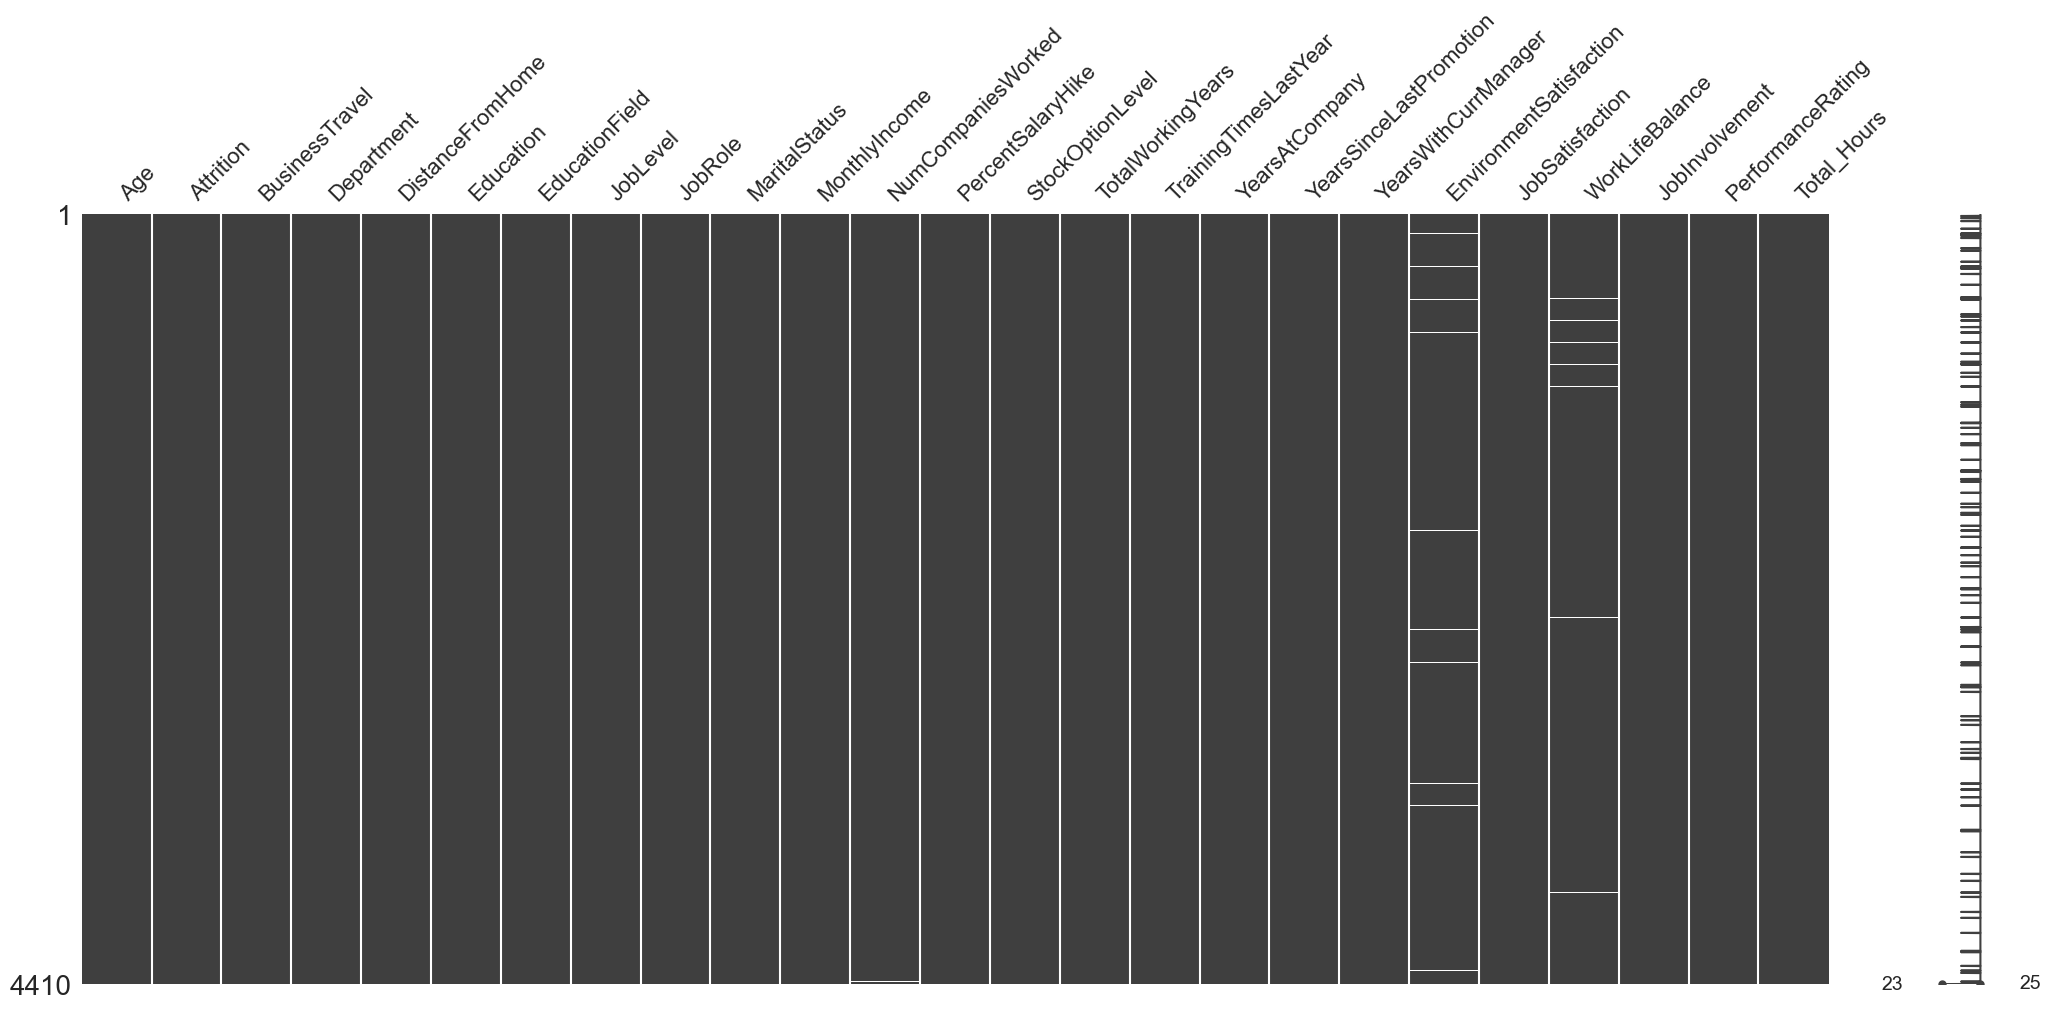

In [25]:
def check_missing_values(df):
    if (df.isnull().sum() > 0).any():
        missing_values = df.isnull().sum()[df.isnull().sum() > 0]
        print("Valeurs manquantes par colonne :")
        print(missing_values)
    else:
        print("Il n'y a pas de valeurs manquantes dans le dataset")
    msno.matrix(df)
    plt.show()


check_missing_values(company_df)

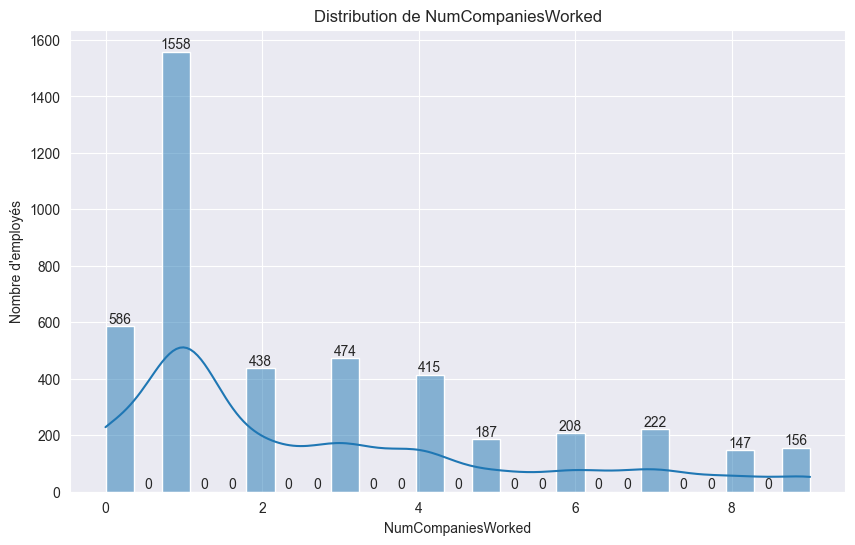

--------------------------------


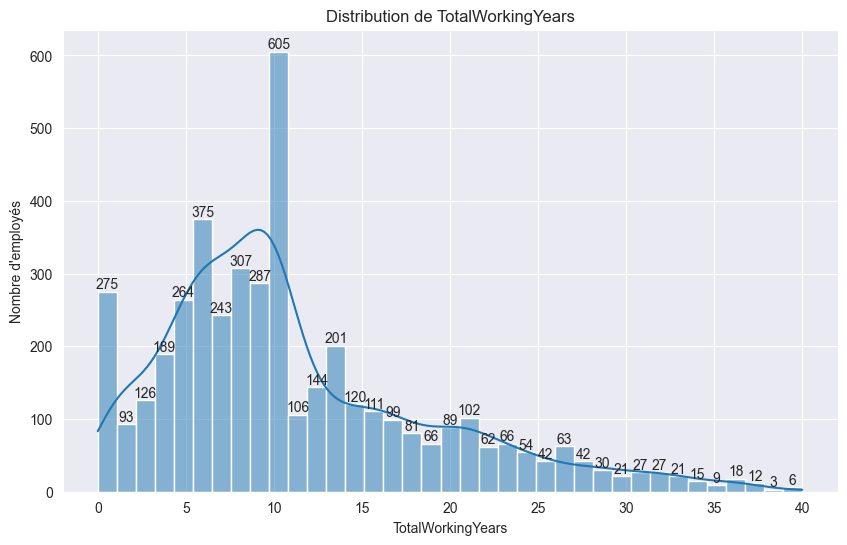

--------------------------------


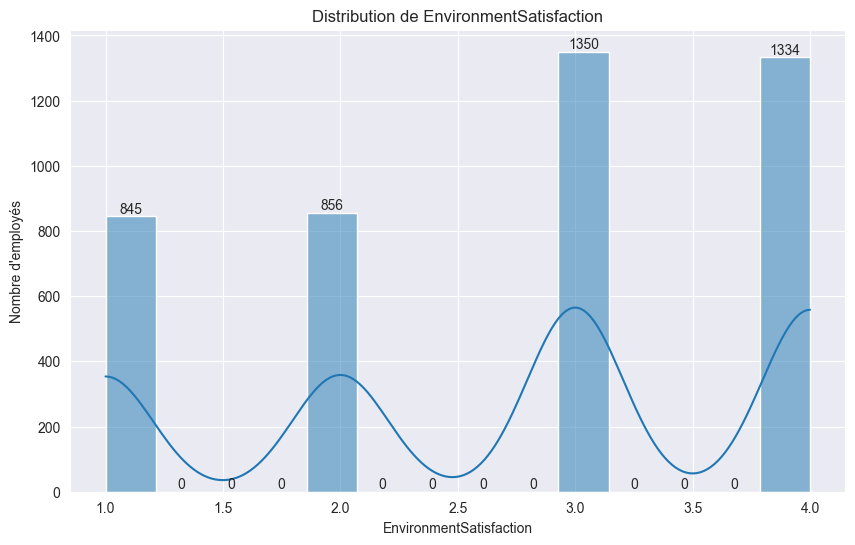

--------------------------------


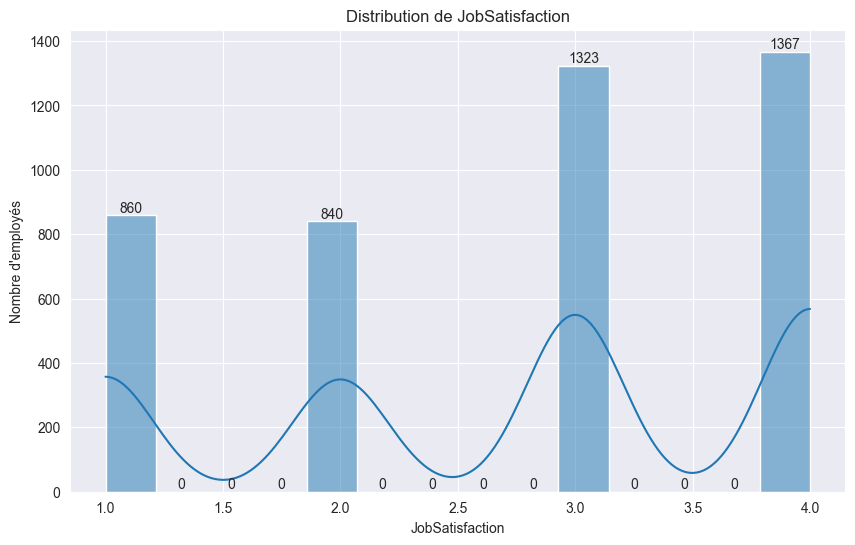

--------------------------------


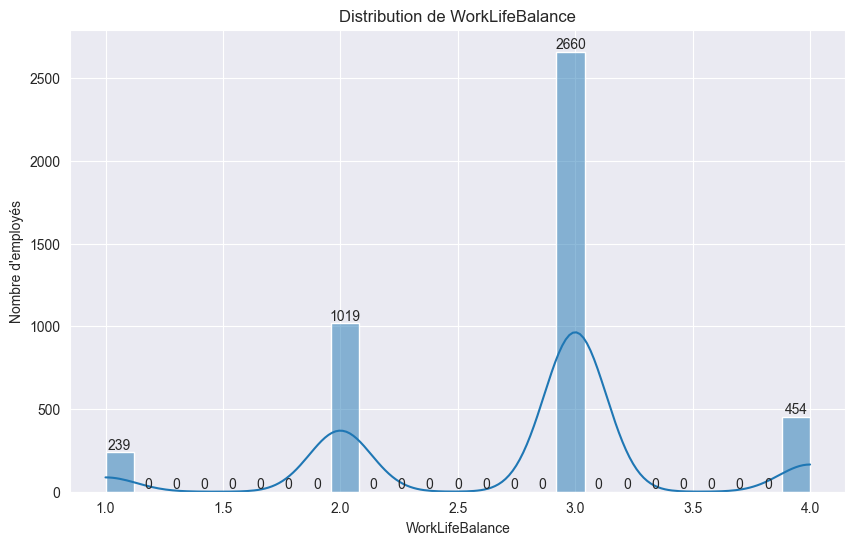

--------------------------------


,NumCompaniesWorked,TotalWorkingYears,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4391.000000,4401.000000,4385.000000,4390.000000,4372.000000
mean,2.694830,11.279936,2.723603,2.728246,2.761436
std,2.498887,7.782222,1.092756,1.101253,0.706245
min,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,6.000000,2.000000,2.000000,2.000000
50%,2.000000,10.000000,3.000000,3.000000,3.000000
75%,4.000000,15.000000,4.000000,4.000000,3.000000
max,9.000000,40.000000,4.000000,4.000000,4.000000


In [26]:
# Distribution des colonnes présentant des valeurs manquantes
missing_values_columns = ['NumCompaniesWorked', 'TotalWorkingYears', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']
for column in missing_values_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(company_df[column], kde=True)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Nombre d\'employés')

    for i in ax.containers:
        ax.bar_label(i)

    plt.show()
    print(DELIMITER)
company_df[missing_values_columns].describe()

---

### 6. <a id='doublons'>Gestion des valeurs dupliquées</a>

In [27]:
def check_duplicates(df):
    if df.duplicated().sum() > 0:
        print(f"Nombre de valeurs dupliquées : {df.duplicated().sum()}")
        merged_dataset = df.drop_duplicates()
        print(f"Nombre de lignes après suppression des doublons : {merged_dataset.shape[0]}")
    else:
        print("Il n'y a pas de valeurs dupliquées dans le dataset")


check_duplicates(company_df)

Il n'y a pas de valeurs dupliquées dans le dataset


---

### 7. <a id='types'>Vérification des types de données</a>

In [28]:
#Valeurs numériques
numerical_columns = company_df.select_dtypes(include=['int64', 'float64']).columns
print(numerical_columns)

#Valeurs non numériques
categorical_columns = company_df.select_dtypes(include=['object', 'category']).columns
print(categorical_columns)

print(f"Nombre de colonnes traitées : {len(numerical_columns) + len(categorical_columns)}")
print(f"Nombre de colonnes dans le dataset : {company_df.shape[1]}")


Index(['DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating', 'Total_Hours'],
      dtype='object')
Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'EducationField',
       'JobRole', 'MaritalStatus'],
      dtype='object')
Nombre de colonnes traitées : 25
Nombre de colonnes dans le dataset : 25


---

### 8. <a id='pipeline'>Pipeline de traitement des données</a>

In [29]:
num_features = numerical_columns.tolist()
cat_features = categorical_columns.tolist()

# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline pour les variables catégorielles
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline spécifique pour la colonne Attrition
attrition_pipeline = Pipeline([
    ('bool_transform', FunctionTransformer(lambda x: x == 'Yes', validate=False))
])

# Pipeline de preprocessing
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, [col for col in cat_features if col != 'Attrition']),
    ('cat_specific', attrition_pipeline, ['Attrition'])
])

# Appliquer la transformation sur les données d'origine
company_transformed_df = preprocessor.fit_transform(company_df)

cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
cat_one_hot_columns = cat_encoder.get_feature_names_out([col for col in cat_features if col != 'Attrition']).tolist()

# Ajouter la colonne `Attrition` traitée
final_columns = num_features + cat_one_hot_columns + ['Attrition']

# Créer le DataFrame transformé
processed_df = pd.DataFrame(company_transformed_df, columns=final_columns)

# Afficher les premières lignes du DataFrame transformé
processed_df.head()


,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Attrition
0,6.0,2.0,1.0,131160.0,1.0,11.0,0.0,1.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,10.0,1.0,1.0,41890.0,0.0,23.0,1.0,6.0,3.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,17.0,4.0,4.0,193280.0,1.0,15.0,3.0,5.0,2.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,2.0,5.0,3.0,83210.0,3.0,11.0,3.0,13.0,5.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,10.0,1.0,1.0,23420.0,4.0,12.0,2.0,9.0,2.0,6.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


On vient vérifier qu'il n'y a plus de valeurs manquantes dans le dataset :

Il n'y a pas de valeurs manquantes dans le dataset


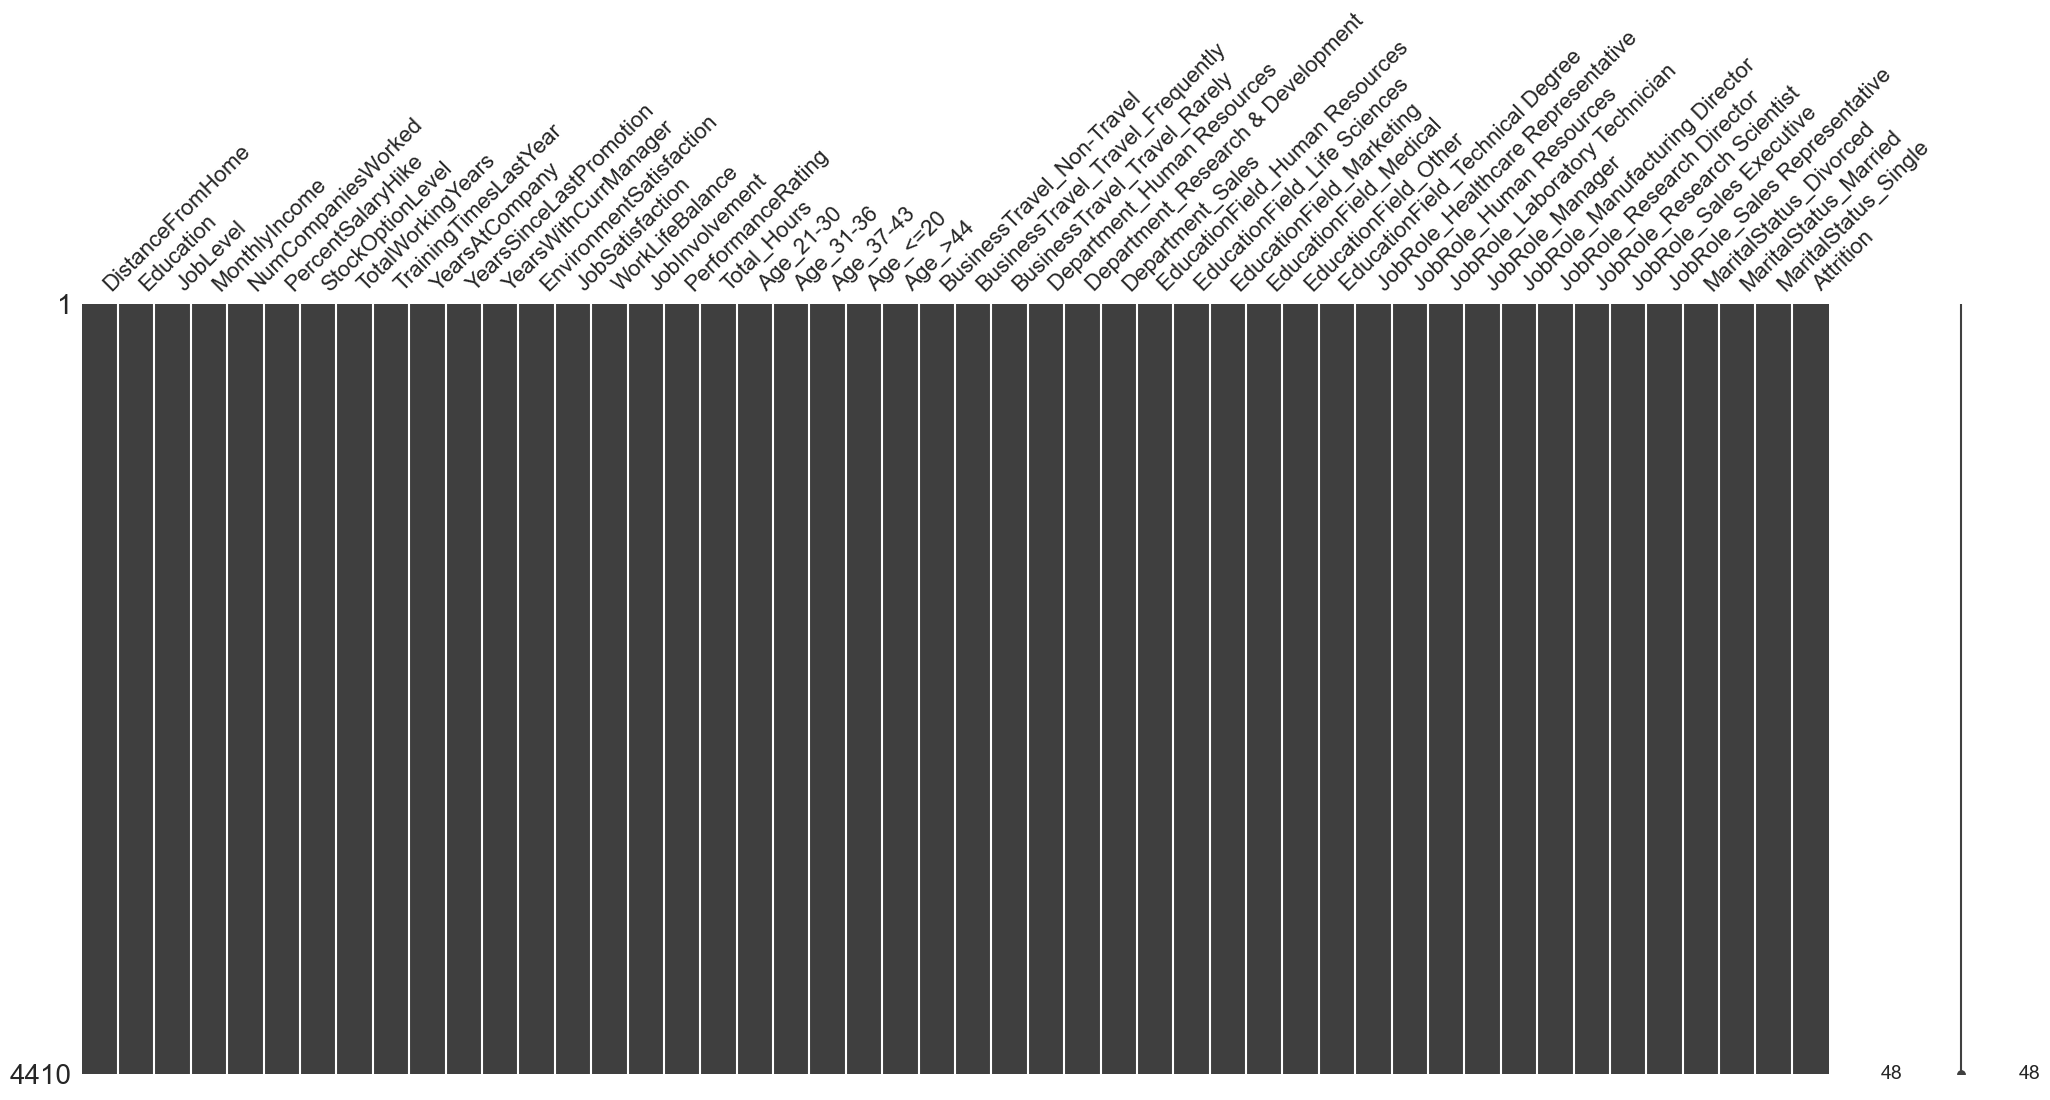

In [30]:
check_missing_values(processed_df)

**EDA** A présent, on va venir réaliser une analyse exploratoire des données pour mieux comprendre les différentes variables et leur impact sur l'attrition des employés.

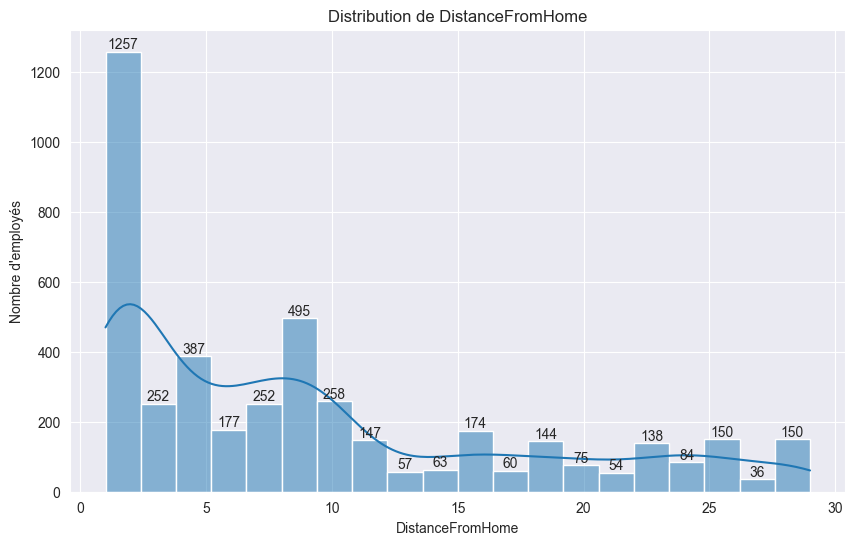

--------------------------------


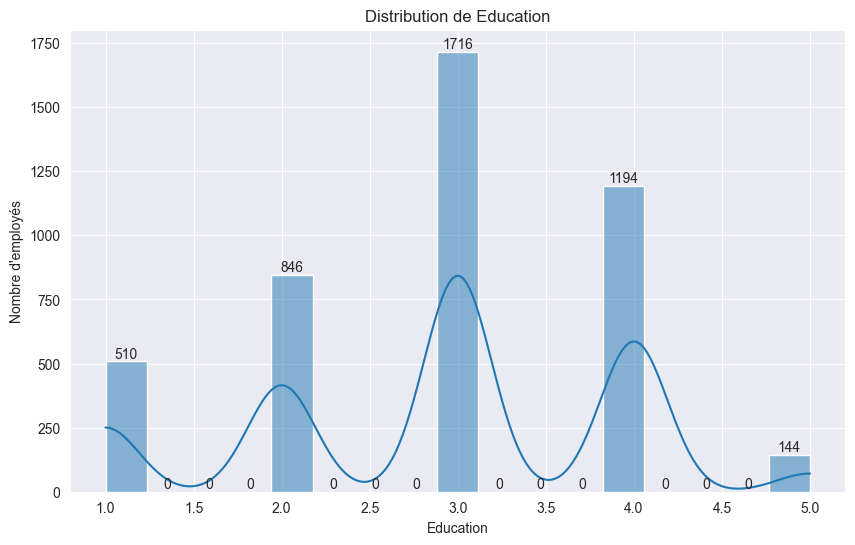

--------------------------------


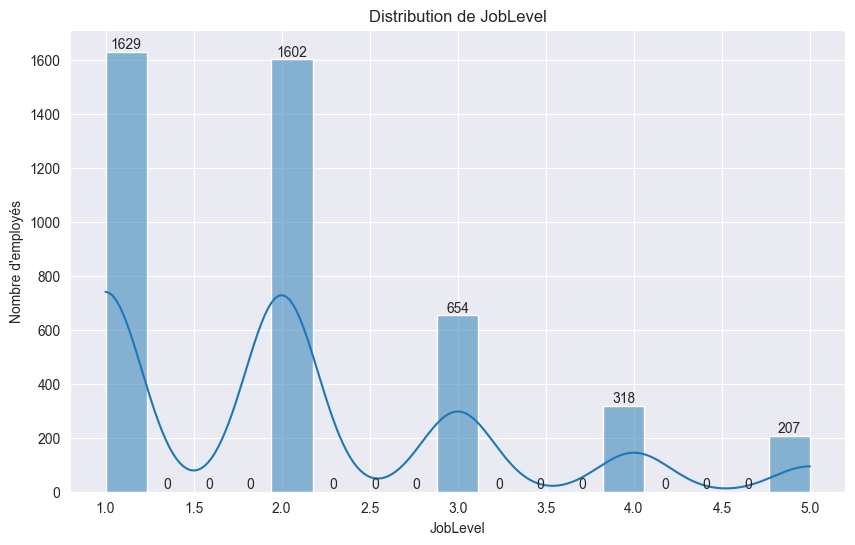

--------------------------------


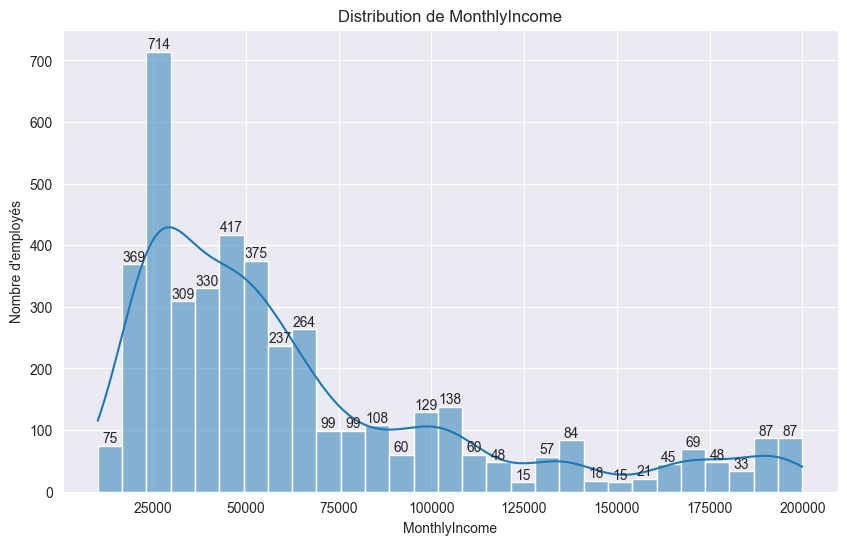

--------------------------------


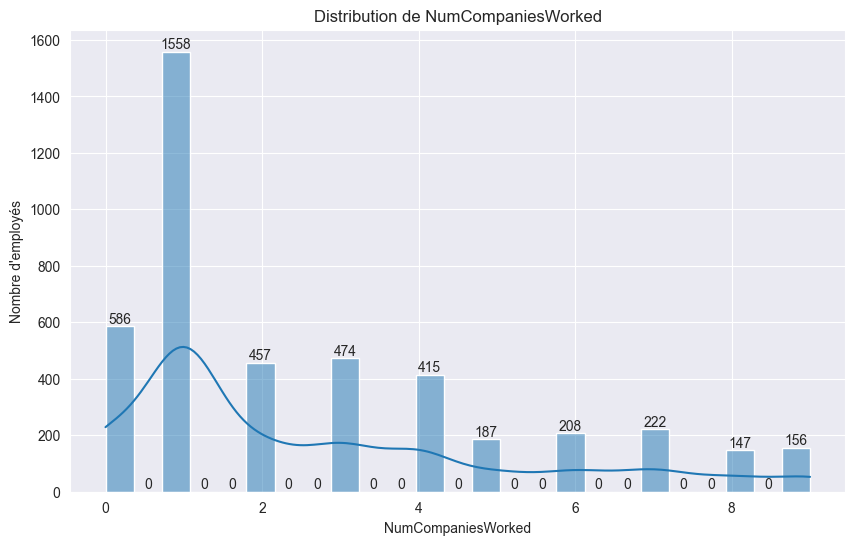

--------------------------------


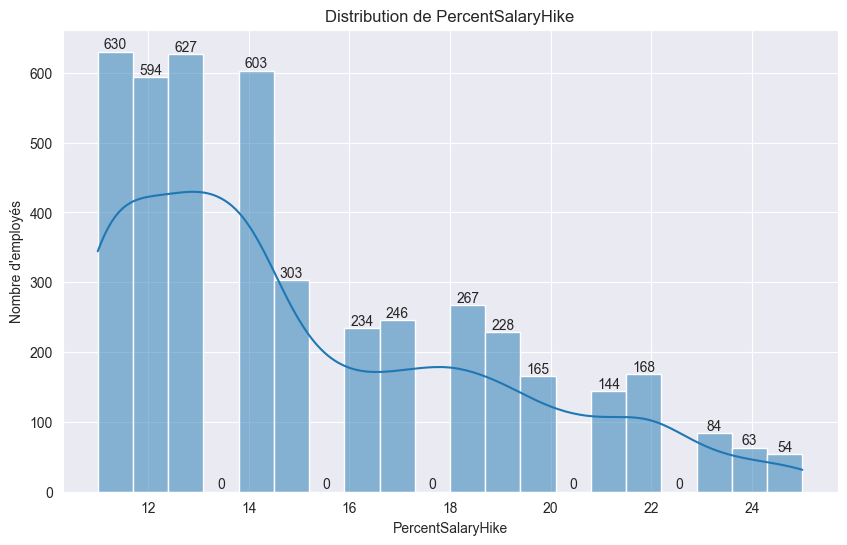

--------------------------------


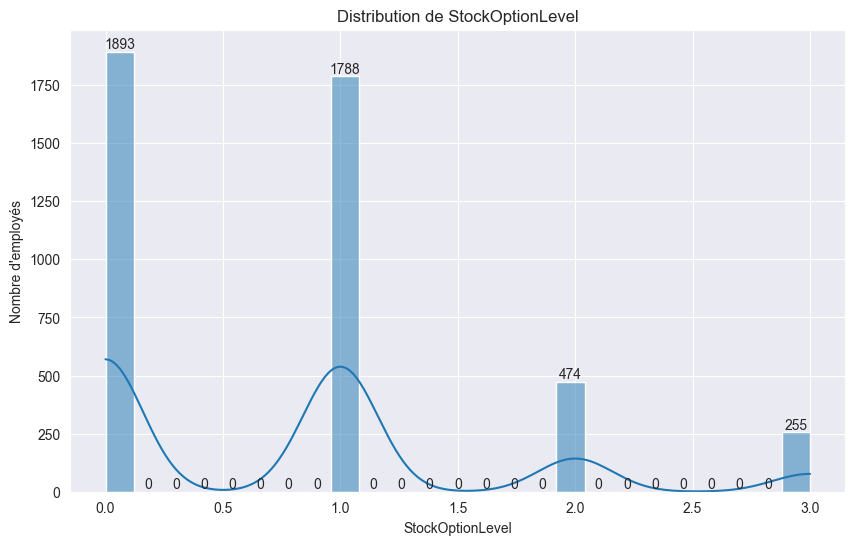

--------------------------------


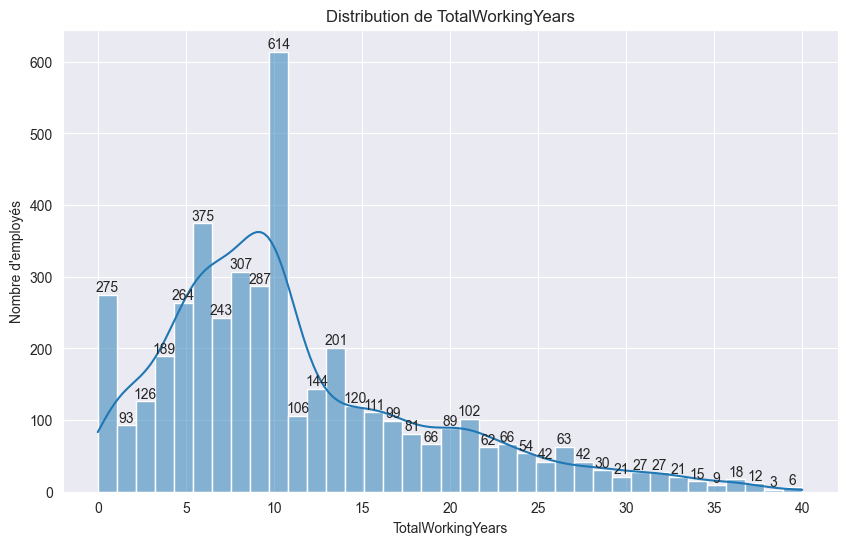

--------------------------------


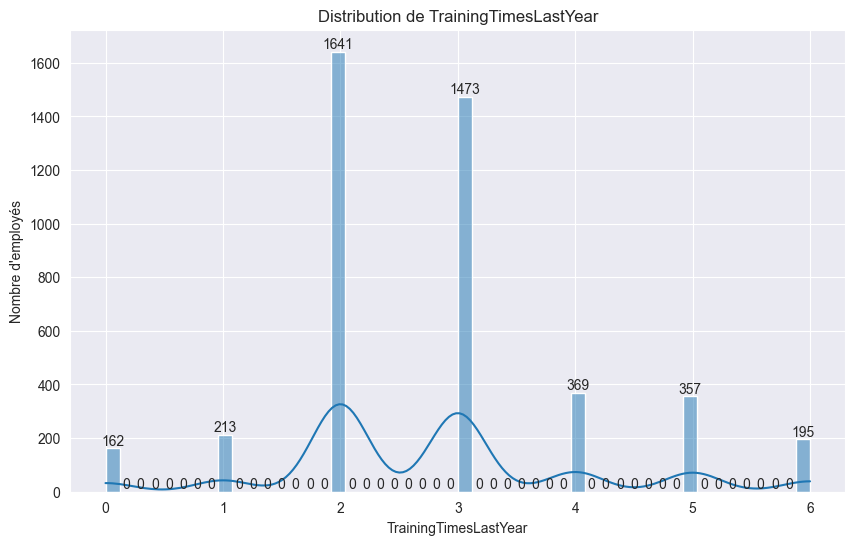

--------------------------------


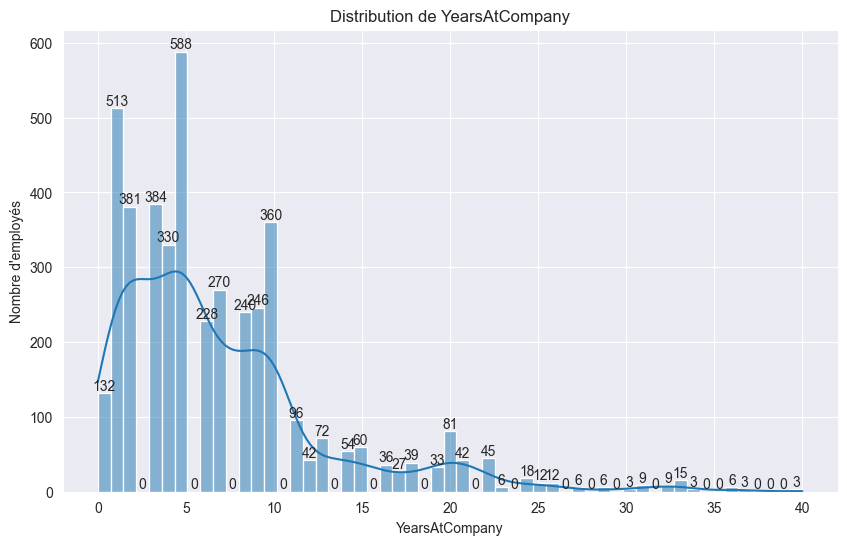

--------------------------------


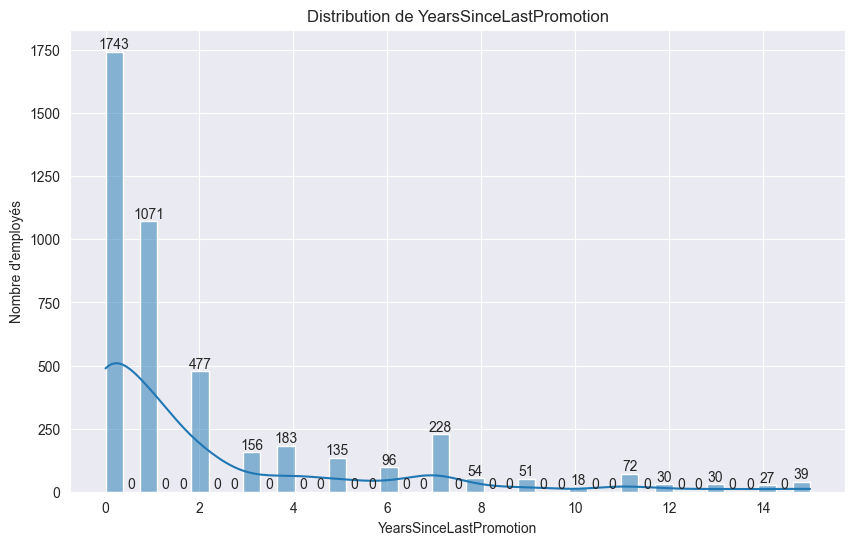

--------------------------------


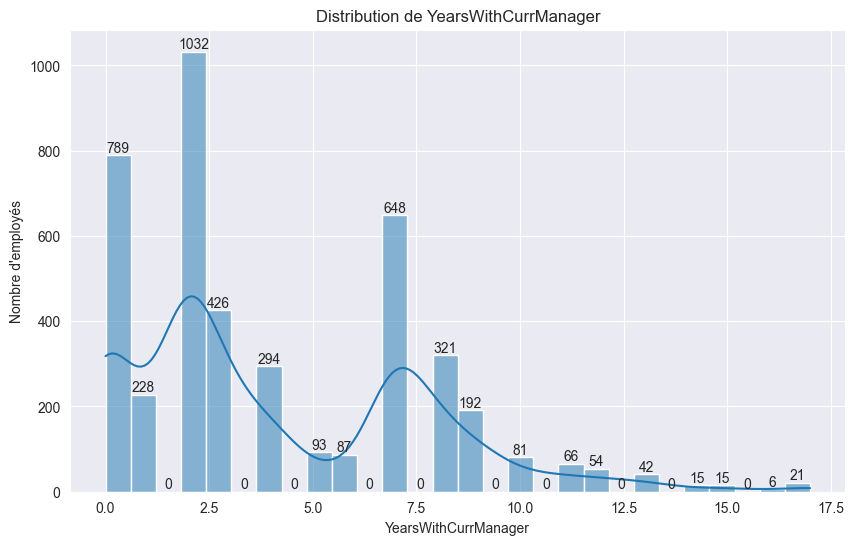

--------------------------------


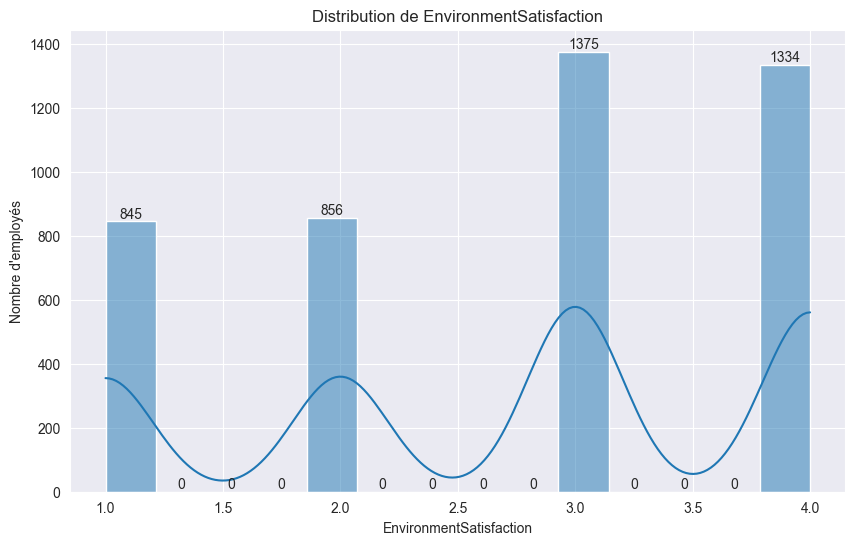

--------------------------------


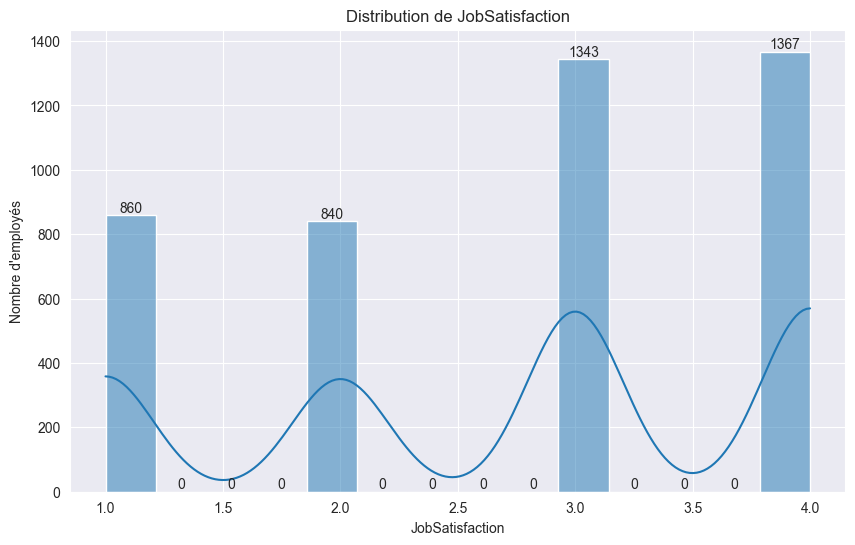

--------------------------------


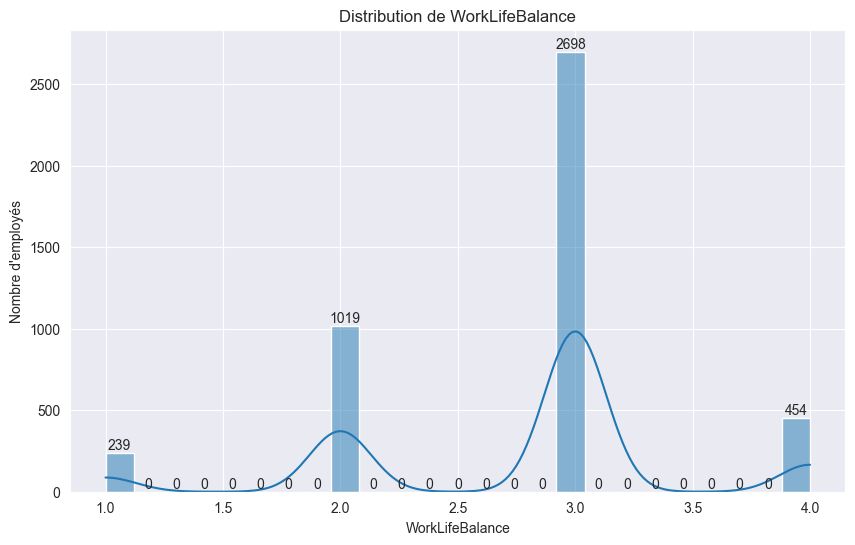

--------------------------------


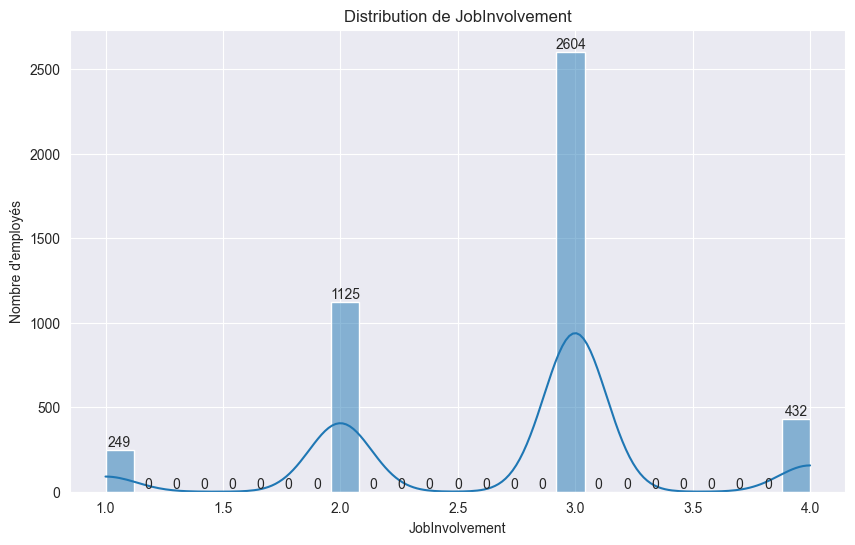

--------------------------------


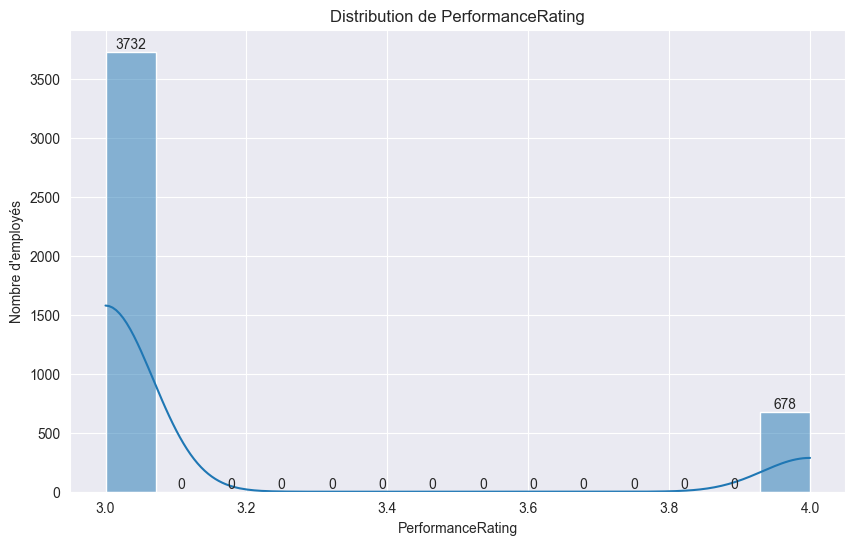

--------------------------------


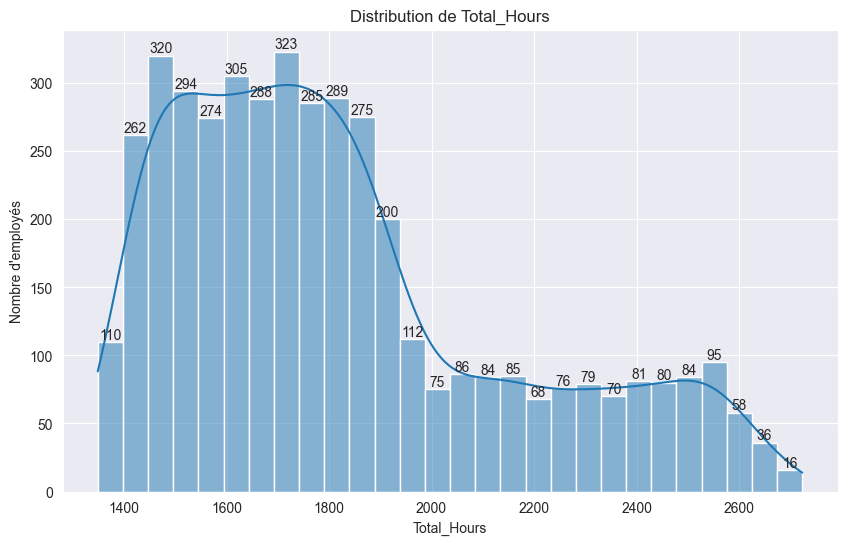

--------------------------------


In [31]:
# Analyse des colonnes numériques
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(processed_df[column], kde=True)
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Nombre d\'employés')

    for i in ax.containers:
        ax.bar_label(i)

    plt.show()
    print(DELIMITER)

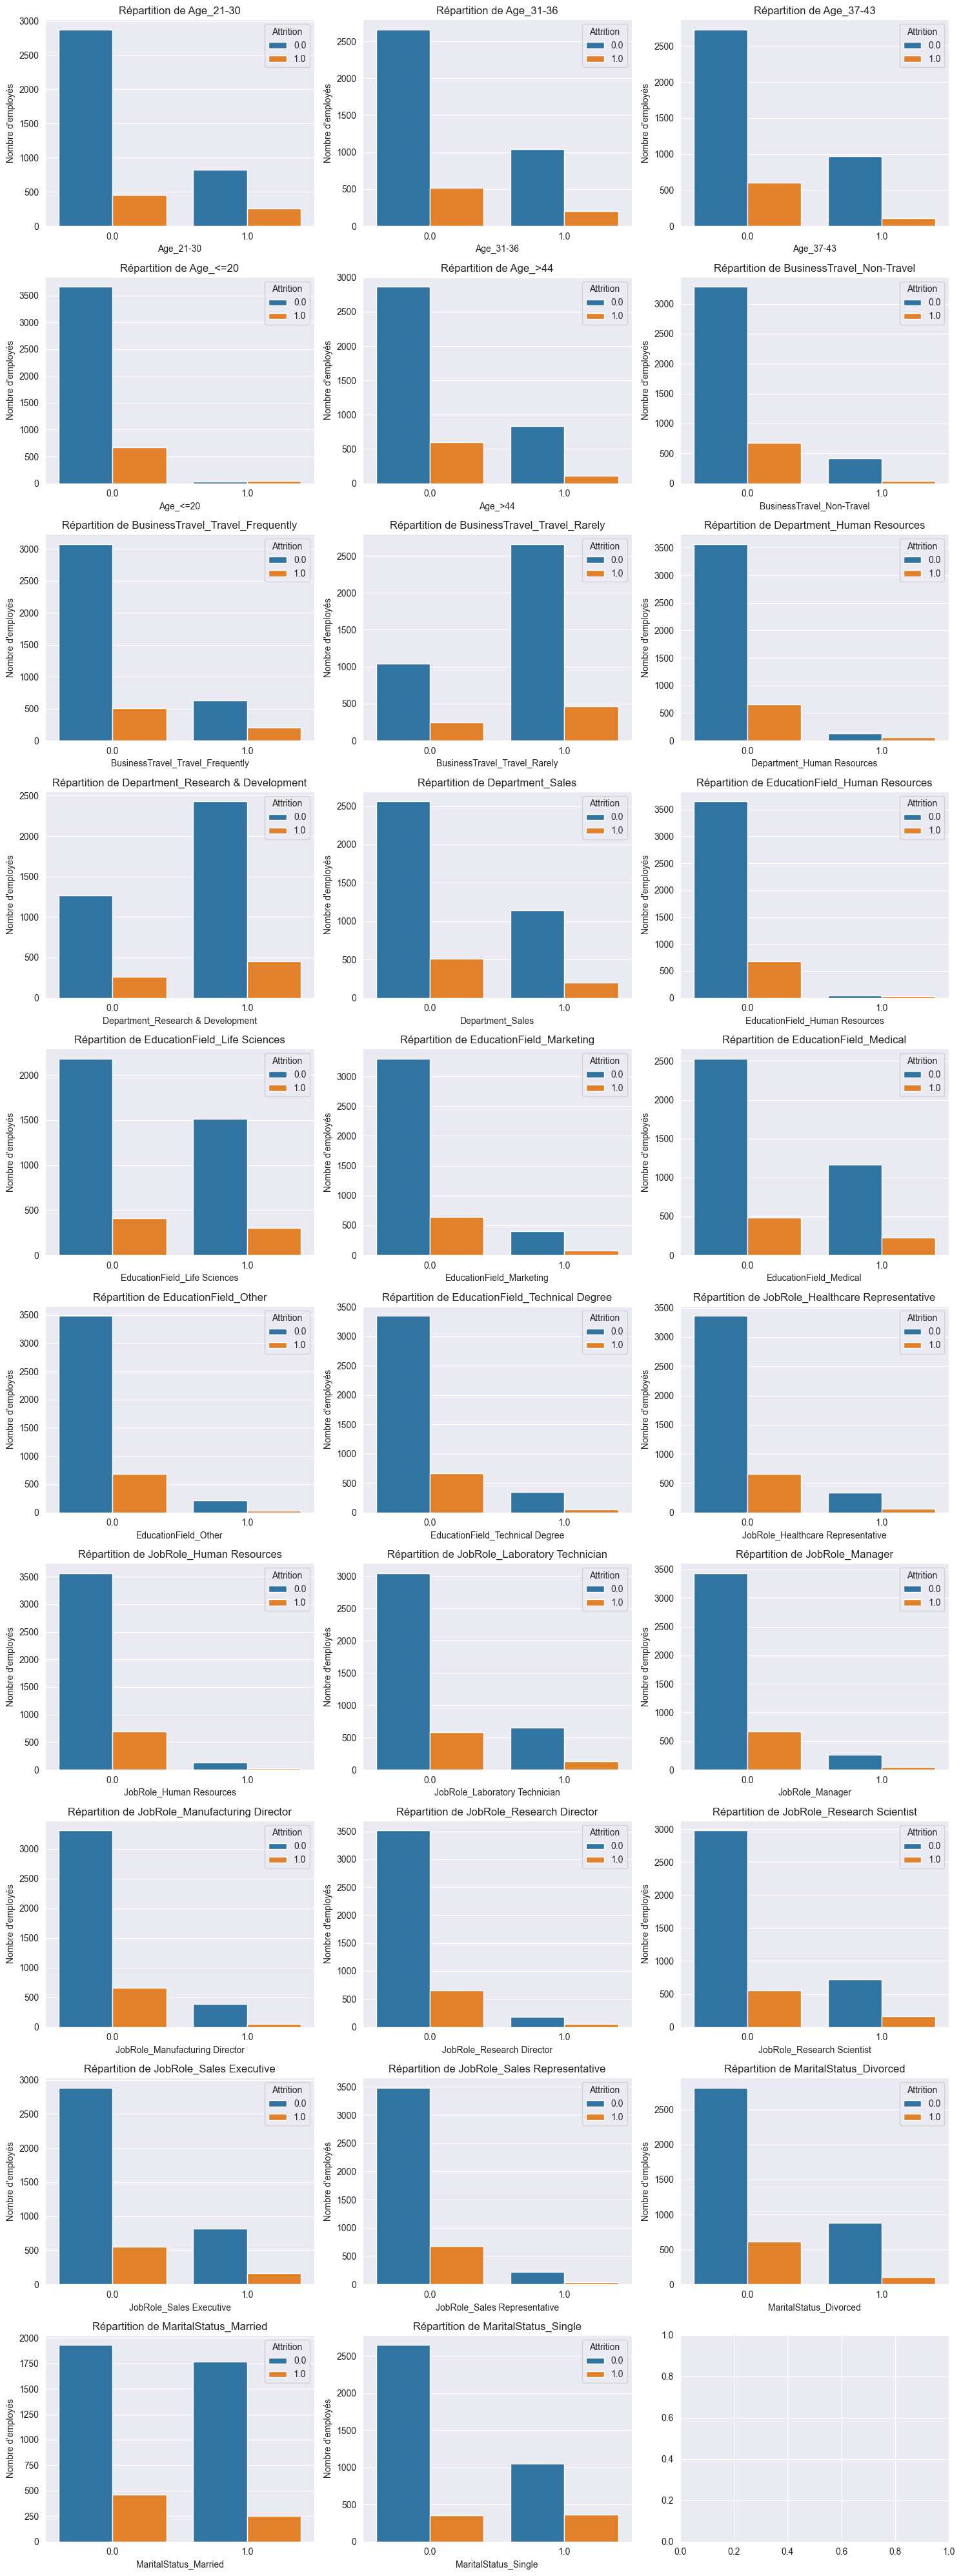

In [32]:
# Définir la disposition :
num_cols = 3
num_rows = (len(cat_one_hot_columns) + 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

axes = axes.flatten() if num_rows > 1 else [axes]

for i, column in enumerate(cat_one_hot_columns):
    sns.countplot(data=processed_df, x=column, hue='Attrition', ax=axes[i])
    axes[i].set_title(f'Répartition de {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Nombre d\'employés')

# Ajuster l'espace entre les sous-graphiques
plt.tight_layout()
plt.show()


On remarque que les variables numériques suivent une distribution normale, ce qui est un bon point pour l'entraînement des modèles.
Pour les variables catégorielles, on peut voir que les employés célibataires ont plus tendance à quitter l'entreprise. De plus, les employés qui voyagent fréquemment ont également plus de chances de quitter l'entreprise.

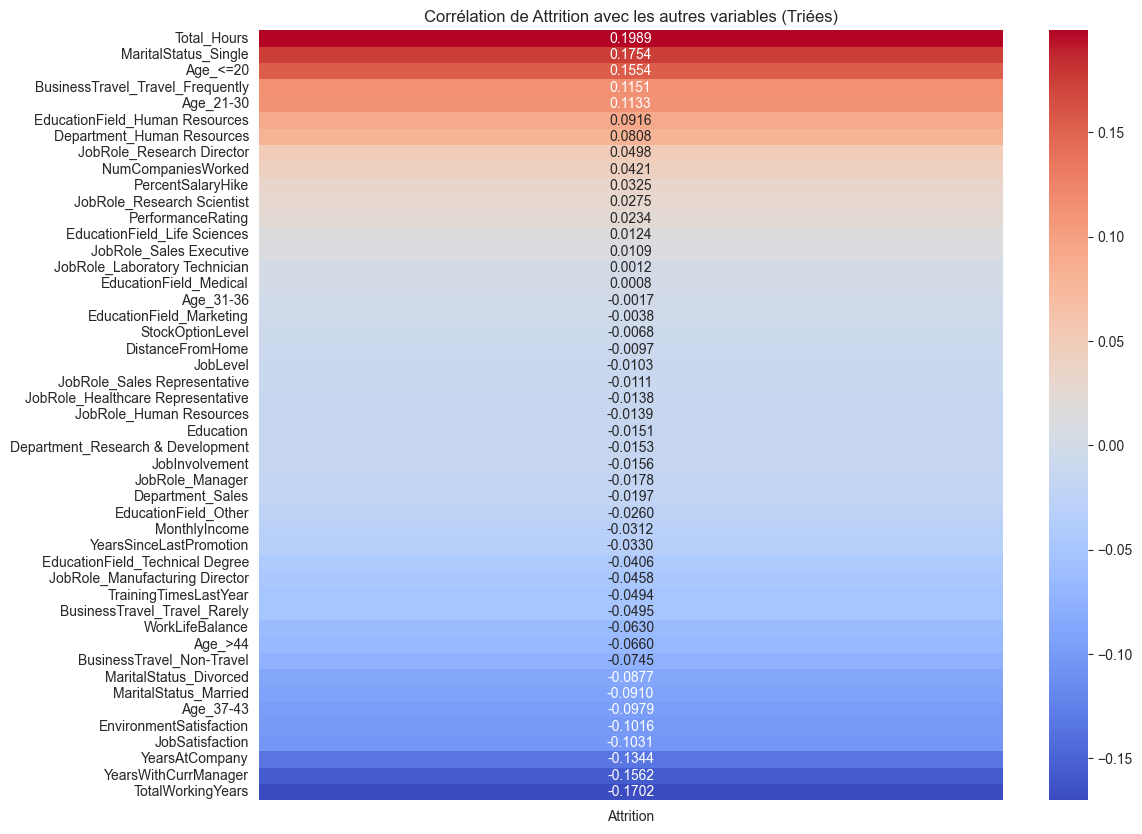

In [33]:
# Créer la matrice de corrélation
corr_matrix = processed_df.corr()

# Extraire la ligne de corrélation de 'Attrition'
corr_attrition = corr_matrix.loc['Attrition'].drop('Attrition')  # Supprimer la corrélation d'Attrition avec lui-même

# Trier les corrélations par ordre décroissant
corr_attrition_sorted = corr_attrition.sort_values(ascending=False)

# Visualiser uniquement la ligne de corrélation d'Attrition
plt.figure(figsize=(12, 10))
sns.heatmap(corr_attrition_sorted.to_frame(), annot=True, fmt='.4f', cmap='coolwarm', cbar=True)

# Ajouter le titre
plt.title('Corrélation de Attrition avec les autres variables (Triées)')
plt.show()


On remarque alors que certaines variables ont un coefficient positif vis-à-vis de notre variable cible. Nous allons afficher la répartition de l'attrition selon ces variables.

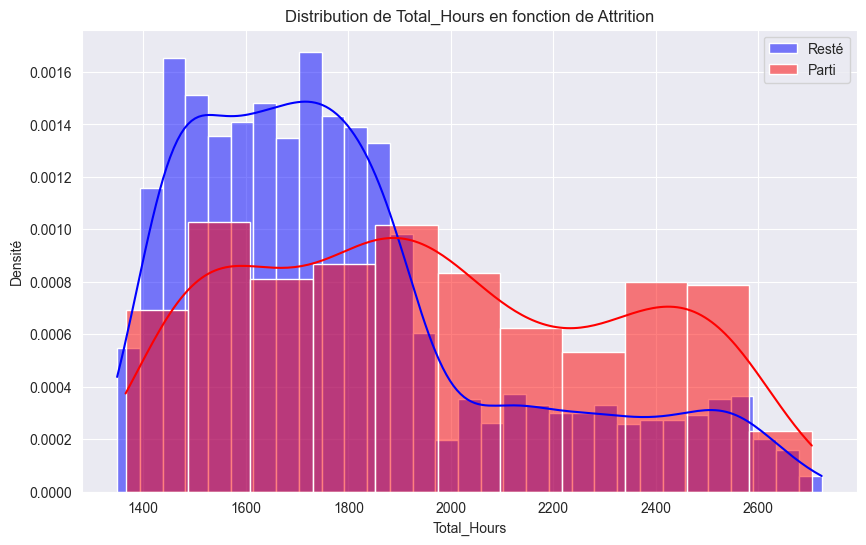

--------------------------------


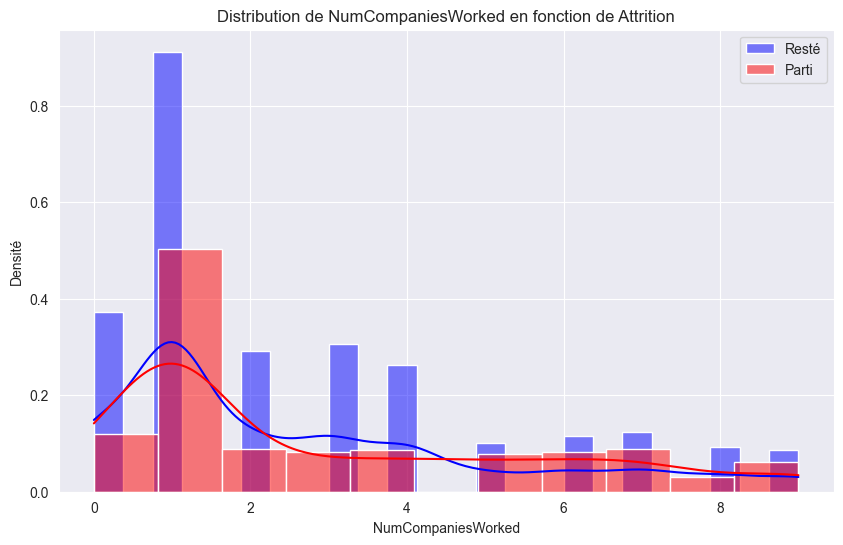

--------------------------------


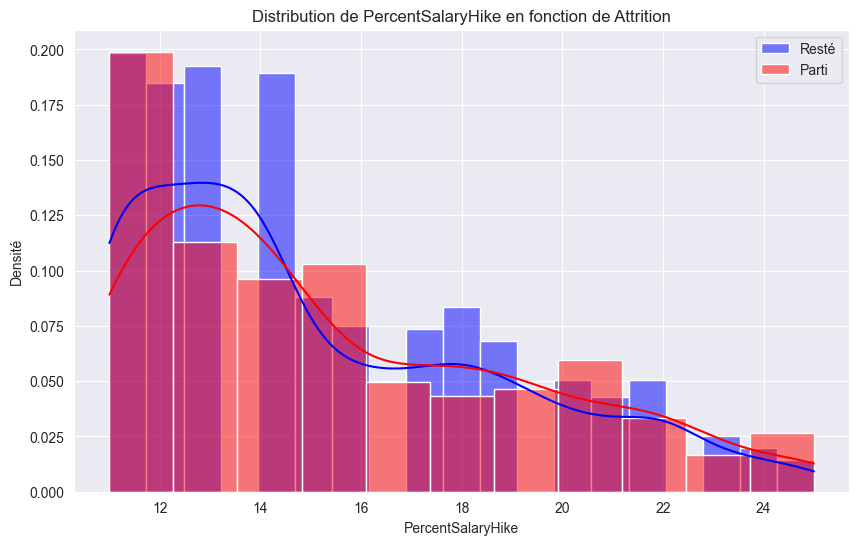

--------------------------------


In [34]:
# Analyse des colonnes numériques en fonction d'Attrition
correlation_columns = ['Total_Hours', 'NumCompaniesWorked', 'PercentSalaryHike']
for column in correlation_columns:
    plt.figure(figsize=(10, 6))

    # Séparer les données en fonction de 'Attrition' (0 = resté, 1 = parti)
    sns.histplot(processed_df[processed_df['Attrition'] == 0][column], kde=True, color='blue', label='Resté',
                 stat='density')
    sns.histplot(processed_df[processed_df['Attrition'] == 1][column], kde=True, color='red', label='Parti',
                 stat='density')

    # Ajouter le titre et les légendes
    plt.title(f'Distribution de {column} en fonction de Attrition')
    plt.xlabel(column)
    plt.ylabel('Densité')
    plt.legend()

    # Ajouter des labels aux barres
    plt.show()
    print(DELIMITER)


On remarque que pour une approche linéaire, les variables les plus corrélées avec l'attrition sont : Total_Hours, MaritalStatus_Single, BusinessTravel_Travel_Frequently, EducationField_Human Resources, Department_Human Resources, JobRole_Research Director et NumCompaniesWorked


Cependant, il faut faire attention car il s'agit seulement des relations linéaires, il est possible que d'autres variables aient un impact sur l'attrition des employés.

### 7. <a id='doublons'>Ajout et choix des modèles</a>

Afin d'obtenir un résultat précis, on vient utiliser la classe StratifiedShuffleSplit pour obtenir des splits stratifiés. On va ensuite entraîner différents modèles de classification pour prédire l'attrition des employés.

In [35]:
def train_and_evaluate_model(models_selected, n_split):
    stratified_split = StratifiedShuffleSplit(n_splits=n_split, test_size=0.2, random_state=42)

    # Initialisation des dictionnaires pour stocker les résultats
    accuracies = {}
    roc_aucs = {}
    training_time_taken = {}
    predict_time_taken = {}

    # Initialisation des listes pour chaque modèle
    for model in models_selected:
        model_name = model.__class__.__name__
        print(f"\nÉvaluation du modèle : {model_name}")
        accuracies[model_name] = []
        roc_aucs[model_name] = []
        training_time_taken[model_name] = []
        predict_time_taken[model_name] = []

    for train_index, test_index in stratified_split.split(processed_df, processed_df['Attrition']):
        strat_train_set = processed_df.loc[train_index]
        strat_test_set = processed_df.loc[test_index]

        data_train_set = strat_train_set.drop(['Attrition'], axis=1)
        data_labels = strat_train_set['Attrition'].copy()

        # Entraînement et évaluation de chaque modèle
        for model in models_selected:
            model_name = model.__class__.__name__

            start_time = time.time()
            model.fit(data_train_set, data_labels)
            end_time = time.time()

            y_tests = strat_test_set.drop(['Attrition'], axis=1)
            start_time_2 = time.time()
            y_pred = model.predict(y_tests)
            end_time_2 = time.time()

            y_proba = model.predict_proba(y_tests)[:,
                      1]

            # Évaluation des performances pour ce split
            accuracy = accuracy_score(strat_test_set['Attrition'], y_pred)
            roc_auc = roc_auc_score(strat_test_set['Attrition'], y_proba)

            accuracies[model_name].append(accuracy)
            roc_aucs[model_name].append(roc_auc)
            training_time_taken[model_name].append(end_time - start_time)
            predict_time_taken[model_name].append(end_time_2 - start_time_2)

    # Création du DataFrame des résultats
    results_df = pd.DataFrame({
        'Model': list(accuracies.keys()),
        'Average Accuracy': [np.mean(acc) for acc in accuracies.values()],
        'Average ROC AUC': [sum(roc) / len(roc) for roc in roc_aucs.values()],
        'Average Training Time (s)': [sum(time_t) / len(time_t) for time_t in training_time_taken.values()],
        'Average Predict Time (s)': [sum(time_t) / len(time_t) for time_t in predict_time_taken.values()]
    })

    print("\nRésultats finaux :")
    return results_df



In [36]:
# Initialisation des modèles
decision_tree_model = DecisionTreeClassifier()
logistic_model = LogisticRegression()
pd.set_option('display.float_format', '{:.4f}'.format)

models = [decision_tree_model, logistic_model]
train_and_evaluate_model(models, 5)


Évaluation du modèle : DecisionTreeClassifier

Évaluation du modèle : LogisticRegression

Résultats finaux :


,Model,Average Accuracy,Average ROC AUC,Average Training Time (s),Average Predict Time (s)
0,DecisionTreeClassifier,0.9760,0.9527,0.0356,0.0012
1,LogisticRegression,0.8410,0.7239,0.0476,0.0016


In [44]:
param_grids = {
    "DecisionTreeClassifier": {
        "max_depth": [3, 5, 10, 15, None],
    }
}
best_params = {}
best_scores = {}
model = DecisionTreeClassifier()
model_name = model.__class__.__name__

X = processed_df.drop('Attrition', axis=1)
y = processed_df['Attrition']

# GridSearchCV
grid_search = GridSearchCV(
    model, param_grids[model_name],
    cv=5, scoring="accuracy"
)

grid_search.fit(X, y)

print(f"Meilleurs paramètres pour {model_name} : {grid_search.best_params_}")
print(f"Score (Accuracy) : {grid_search.best_score_:.4f}")



Meilleurs paramètres pour DecisionTreeClassifier : {'max_depth': None}
Score (Accuracy) : 0.9825


In [39]:
importances = decision_tree_model.feature_importances_
feature_importances = pd.Series(importances, index=final_columns[:-1])
feature_importances

DistanceFromHome                    0.0539
Education                           0.0457
JobLevel                            0.0256
MonthlyIncome                       0.0585
NumCompaniesWorked                  0.0518
PercentSalaryHike                   0.0278
StockOptionLevel                    0.0175
TotalWorkingYears                   0.1014
TrainingTimesLastYear               0.0317
YearsAtCompany                      0.0447
YearsSinceLastPromotion             0.0308
YearsWithCurrManager                0.0417
EnvironmentSatisfaction             0.0521
JobSatisfaction                     0.0388
WorkLifeBalance                     0.0319
JobInvolvement                      0.0206
PerformanceRating                   0.0070
Total_Hours                         0.0955
Age_21-30                           0.0052
Age_31-36                           0.0067
Age_37-43                           0.0000
Age_<=20                            0.0000
Age_>44                             0.0034
BusinessTra